In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('wine').getOrCreate()

In [2]:
# Let's read in the data. Note that it's in the format of JSON
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,DoubleType)

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv")
whiteData = spark.read.format("csv").option("header", "true").load("./data/winequality-white.csv")
redData.printSchema()
col=redData.columns

data_schema = [StructField(col[0],DoubleType(),True),
              StructField(col[1],DoubleType(),True),
              StructField(col[2],DoubleType(),True),
              StructField(col[3],DoubleType(),True),
              StructField(col[4],DoubleType(),True),
              StructField(col[5],DoubleType(),True),
              StructField(col[6],DoubleType(),True),
              StructField(col[7],DoubleType(),True),
              StructField(col[8],DoubleType(),True),
              StructField(col[9],DoubleType(),True),
              StructField(col[10],DoubleType(),True),
              StructField(col[11],IntegerType(),True)]
final_struct = StructType(fields=data_schema)

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv", schema=final_struct)
whiteData = spark.read.format("csv").option("header", "true").load("./data/winequality-white.csv", schema=final_struct)

redData.printSchema()

root
 |-- fixed acidity: string (nullable = true)
 |-- volatile acidity: string (nullable = true)
 |-- citric acid: string (nullable = true)
 |-- residual sugar: string (nullable = true)
 |-- chlorides: string (nullable = true)
 |-- free sulfur dioxide: string (nullable = true)
 |-- total sulfur dioxide: string (nullable = true)
 |-- density: string (nullable = true)
 |-- pH: string (nullable = true)
 |-- sulphates: string (nullable = true)
 |-- alcohol: string (nullable = true)
 |-- quality: string (nullable = true)

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable 

In [3]:
from pyspark.sql.functions import lit

redData=redData.withColumn("color", lit('red'))
whiteData=whiteData.withColumn("color", lit('white'))
print(redData.columns)
print(whiteData.columns)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']


In [4]:
combinedData = redData.union(whiteData)
col=combinedData.columns

print(combinedData.dtypes)

print(combinedData.describe(col[0:5]).show())
print(combinedData.describe(col[5:10]).show())
print(combinedData.describe(col[10:]).show())

[('fixed acidity', 'double'), ('volatile acidity', 'double'), ('citric acid', 'double'), ('residual sugar', 'double'), ('chlorides', 'double'), ('free sulfur dioxide', 'double'), ('total sulfur dioxide', 'double'), ('density', 'double'), ('pH', 'double'), ('sulphates', 'double'), ('alcohol', 'double'), ('quality', 'int'), ('color', 'string')]
+-------+-----------------+-------------------+-------------------+------------------+-------------------+
|summary|    fixed acidity|   volatile acidity|        citric acid|    residual sugar|          chlorides|
+-------+-----------------+-------------------+-------------------+------------------+-------------------+
|  count|             6497|               6497|               6497|              6497|               6497|
|   mean| 7.21530706479913|0.33966599969216654|0.31863321533014727|  5.44323533938742|0.05603386178236105|
| stddev|1.296433757799814|0.16463647408467896|0.14531786489759146|4.7578037431474165|0.03503360137245908|
|    min|    

In [5]:
# 6 times StdDev - https://towardsdatascience.com/outlier-detection-an-etl-tutorial-with-spark-f4197eb84a7b

# Also, it's good practice to use your sales average to fill missing data. 
from pyspark.sql.functions import countDistinct,avg,stddev,format_number

for column in col[0:10]:
    tempAvg=combinedData.select(avg(column)).collect()[0][0]
    tempStd=combinedData.select(stddev(column)).collect()[0][0]
    upBound=tempAvg+(6*tempStd)
    lowBound=tempAvg-(6*tempStd)
    #print(str(tempAvg)+ str(" ")+str(tempStd)+ str(" ")+str(upBound)+ str(" ") + str(lowBound))
    temp = combinedData.filter(combinedData[column] < upBound).select(column)
    temp = temp.filter(temp[column] > lowBound).select(column)
    print(str(column) + str(" ")+ str(temp.count()) + str(" of ") + str(combinedData.select(column).count()))

fixed acidity 6490 of 6497
volatile acidity 6494 of 6497
citric acid 6495 of 6497
residual sugar 6496 of 6497
chlorides 6469 of 6497
free sulfur dioxide 6494 of 6497
total sulfur dioxide 6497 of 6497
density 6496 of 6497
pH 6497 of 6497
sulphates 6489 of 6497


In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

for column in col[0:10]:
    fig1, ax1 = plt.subplots()
    ax1.set_title(column)
    plt.boxplot(x=np.asarray(combinedData.select(column).collect()),vert=False)

Text(0,0.5,'Wine Color')

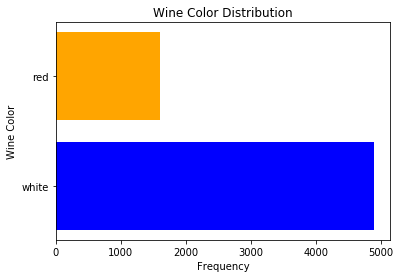

In [7]:
colorCnt = combinedData.groupBy('color').count()

fig1, ax1 = plt.subplots()
ax1.set_title("Wine Color Distribution")
plt.barh(y=[colorCnt.collect()[0][0],colorCnt.collect()[1][0]],
         width=[colorCnt.collect()[0][1],colorCnt.collect()[1][1]],
         color=["blue","orange"])
plt.xlabel("Frequency")
plt.ylabel("Wine Color")

Text(0,0.5,'Frequency')

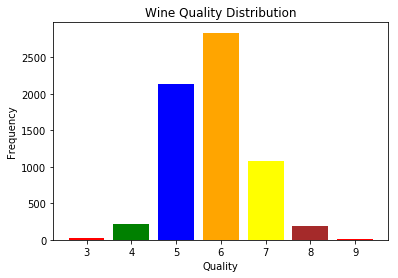

In [8]:
qualityCnt = combinedData.groupBy('quality').count()
qualityCnt.collect()

fig1, ax1 = plt.subplots()
ax1.set_title("Wine Quality Distribution")
plt.bar(x=[qualityCnt.collect()[1][0],
           qualityCnt.collect()[4][0],
           qualityCnt.collect()[2][0],
           qualityCnt.collect()[0][0],
           qualityCnt.collect()[6][0],
           qualityCnt.collect()[5][0],
           qualityCnt.collect()[3][0]],
         height=[qualityCnt.collect()[1][1],
           qualityCnt.collect()[4][1],
           qualityCnt.collect()[2][1],
           qualityCnt.collect()[0][1],
           qualityCnt.collect()[6][1],
           qualityCnt.collect()[5][1],
           qualityCnt.collect()[3][1]],
       color=["red","green","blue","orange","yellow","brown","black"])
plt.xlabel("Quality")
plt.ylabel("Frequency")

In [9]:
print("Before NA Remove: ")
for column in col:
    print(str(column) +" " + str(combinedData.select(column).count()))
combinedData=combinedData.na.drop()
print("")
print("After NA Remove: ")
for column in col:
    print(str(column) +" " + str(combinedData.select(column).count()))

Before NA Remove: 
fixed acidity 6497
volatile acidity 6497
citric acid 6497
residual sugar 6497
chlorides 6497
free sulfur dioxide 6497
total sulfur dioxide 6497
density 6497
pH 6497
sulphates 6497
alcohol 6497
quality 6497
color 6497

After NA Remove: 
fixed acidity 6497
volatile acidity 6497
citric acid 6497
residual sugar 6497
chlorides 6497
free sulfur dioxide 6497
total sulfur dioxide 6497
density 6497
pH 6497
sulphates 6497
alcohol 6497
quality 6497
color 6497


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+
|          7.8|           0.965|        0.6|          65.8|    0.074|                8.0|               160.0|1.03898|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+

+----+---------+-------+-------+-----+
|  pH|sulphates|alcohol|quality|color|
+----+---------+-------+-------+-----+
|3.39|     0.69|   11.7|      6|white|
+----+---------+-------+-------+-----+



{'boxes': [<matplotlib.lines.Line2D at 0x7fb809eb6438>],
 'caps': [<matplotlib.lines.Line2D at 0x7fb809eb6e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb809ebab00>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fb809eba6d8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fb809eb6588>,
  <matplotlib.lines.Line2D at 0x7fb809eb6a20>]}

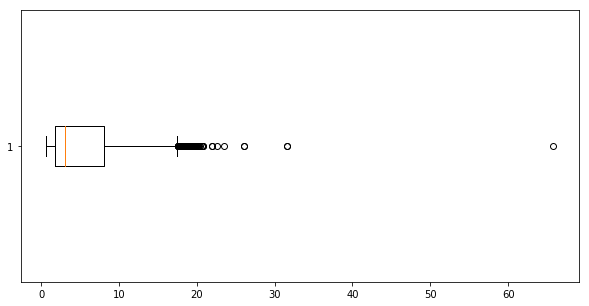

In [10]:
combinedData.select(col[0:8]).filter(combinedData['residual sugar']>50).show()
combinedData.select(col[8:]).filter(combinedData['residual sugar']>50).show()

import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [10, 5]
plt.boxplot(np.array(combinedData.select('residual sugar').collect()),vert=False)